<a href="https://colab.research.google.com/github/mohamedHashem250/DeepLearningArchitecture/blob/main/FC_neuralNetworks/NeuralNetwork_finetuningParameterswithOptuna_part2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##In this notebook, we use oputna to automate hyperparameters [number of layers , neurons, optimizer,batch_size,epochs]
#we use variable number of hidden layers and variable number of neurons.

In [1]:
import tensorflow as tf
import keras
from sklearn.datasets import make_circles

#making 1000 samples
n_samples = 1000
#creating cicles

X,y = make_circles(n_samples,
                   noise = 0.03,
                   random_state=42)

In [2]:
import numpy as np

def plot_decision_boundary(model, X, y):
  """
  Plots the decision boundary created by a model predicting on X.
  This function has been adapted from two phenomenal resources:
   1. CS231n - https://cs231n.github.io/neural-networks-case-study/
   2. Made with ML basics - https://github.com/GokuMohandas/MadeWithML/blob/main/notebooks/08_Neural_Networks.ipynb
  """
  # Define the axis boundaries of the plot and create a meshgrid
  x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
  y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
  xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                       np.linspace(y_min, y_max, 100))

  # Create X values (we're going to predict on all of these)
  x_in = np.c_[xx.ravel(), yy.ravel()] # stack 2D arrays together: https://numpy.org/devdocs/reference/generated/numpy.c_.html

  # Make predictions using the trained model
  y_pred = model.predict(x_in)

  # Check for multi-class
  if model.output_shape[-1] > 1: # checks the final dimension of the model's output shape, if this is > (greater than) 1, it's multi-class
    print("doing multiclass classification...")
    # We have to reshape our predictions to get them ready for plotting
    y_pred = np.argmax(y_pred, axis=1).reshape(xx.shape)
  else:
    print("doing binary classifcation...")
    y_pred = np.round(np.max(y_pred, axis=1)).reshape(xx.shape)

  # Plot decision boundary
  plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
  plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
  plt.xlim(xx.min(), xx.max())
  plt.ylim(yy.min(), yy.max())


In [3]:
import numpy as np
import random

In [4]:
import pandas as pd
circles = pd.DataFrame({
    "X0":X[:,0],
    "X1":X[:,1],
    "label":y})
circles

,X0,X1,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
...,...,...,...
995,0.244054,0.944125,0
996,-0.978655,-0.272373,0
997,-0.136900,-0.810012,1
998,0.670362,-0.767502,0


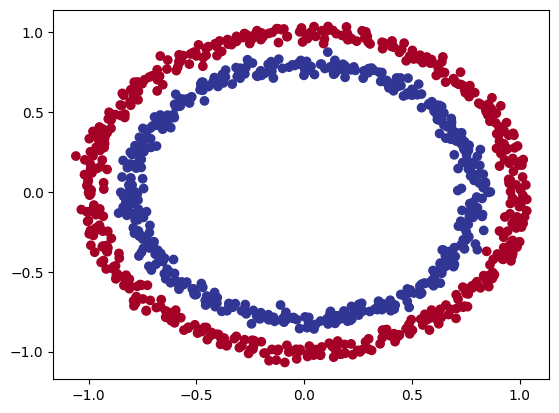

In [5]:
#visualizing with plot
import matplotlib.pyplot as plt
plt.scatter(x=X[:,0],
            y=X[:,1],
            c=y,
            cmap=plt.cm.RdYlBu)

In [6]:
#split data into train and test sets:
X_train , y_train = X[:800], y[:800]
X_test , y_test = X[800:], y[800:]

X_train.shape , X_test.shape

((800, 2), (200, 2))

In [7]:
!pip install optuna
import optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.8 MB/s eta 0:00:00


In [18]:
def create_model_variable_hidden_layers(trial):
  n_hidden_layers = trial.suggest_int('n_hidden_layers', 1, 3)
  model = keras.Sequential()
  for i in range(n_hidden_layers):
    neurons = trial.suggest_categorical('neurons_hidden_layer_{layer}'.format(layer=i+1), [4,8,16,32,64])
    model.add(tf.keras.layers.Dense(units = neurons ,activation = 'relu'))

  model.add(tf.keras.layers.Dense(units = 1, activation = 'sigmoid'))
  #optimizer = trial.suggest_categorical('optimizer', ['adam', 'sgd','rmsprop'])
  #learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)
  model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
  return model

In [ ]:
intial_seed = 42

In [19]:
def objective(trial):
  #to produce the the same result every run
  #tf.random.set_seed(intial_seed)
  #np.random.seed(intial_seed)
  #random.seed(intial_seed)
  #Suggest hyperparameters:
  batch_size = trial.suggest_categorical("batch_size", [32, 64])
  epoch = trial.suggest_categorical("epoch", [40, 60])
  suggested_model = create_model_variable_hidden_layers(trial)

  try:
    #train model:
    history = suggested_model.fit(X_train, y_train, epochs = epoch, batch_size= batch_size, verbose = 1, validation_data = (X_test,y_test) )
    #Evaluate Performance :
    val_acc = max(history.history['val_accuracy'])
  finally:
    print("finished .. ")
    #cleanup to release memory:
    tf.keras.backend.clear_session() #clear the global graph
    #del model
  return val_acc

In [24]:
#first we need to try all hyperparameters like searchgrid
#so we can use GridSampler to "Fore Exploration"
#Define the serach space:
search_space = {
    'batch_size':  [32, 64],
    'epoch' :[40, 60],
    #'optimizer': ['adam', 'sgd','rmsprop'],
    'neurons_hidden_layer_1' : [4,8,16,32,64],
    'neurons_hidden_layer_2' : [4,8,16,32,64],
    'neurons_hidden_layer_3' : [4,8,16,32,64],
    'n_hidden_layers':[ 1,2 ,3]
}
#create a study with GridSampler:
sampler = optuna.samplers.GridSampler(search_space)


In [25]:
study = optuna.create_study(sampler = sampler, direction = 'maximize')


[I 2025-01-19 21:37:03,948] A new study created in memory with name: no-name-a609c5ea-a85d-4ef5-b42e-362f6c56fbbb


In [26]:
#optimize:
study.optimize(objective, n_trials = 2*2*3*5)#the number of search space 3*3*3

Epoch 1/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.4709 - loss: 0.7032 - val_accuracy: 0.5550 - val_loss: 0.6870
Epoch 2/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4515 - loss: 0.6981 - val_accuracy: 0.4950 - val_loss: 0.6870
Epoch 3/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4614 - loss: 0.6925 - val_accuracy: 0.5400 - val_loss: 0.6865
Epoch 4/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4768 - loss: 0.6927 - val_accuracy: 0.5300 - val_loss: 0.6866
Epoch 5/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4905 - loss: 0.6906 - val_accuracy: 0.5050 - val_loss: 0.6862
Epoch 6/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5286 - loss: 0.6852 - val_accuracy: 0.5050 - val_loss: 0.6864
Epoch 7/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4880 - loss: 0.6870 - val_accuracy: 0.5400 - val_loss: 0.6851
Epoch 8/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5436 - loss: 0.6819 - val_accuracy: 0.5650 - val_loss

[I 2025-01-19 21:37:16,119] Trial 0 finished with value: 0.9850000143051147 and parameters: {'batch_size': 32, 'epoch': 60, 'n_hidden_layers': 1, 'neurons_hidden_layer_1': 32}. Best is trial 0 with value: 0.9850000143051147.


Epoch 1/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.4885 - loss: 0.7675 - val_accuracy: 0.5450 - val_loss: 0.7511
Epoch 2/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4730 - loss: 0.7638 - val_accuracy: 0.5300 - val_loss: 0.7413
Epoch 3/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4553 - loss: 0.7534 - val_accuracy: 0.5150 - val_loss: 0.7338
Epoch 4/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4975 - loss: 0.7273 - val_accuracy: 0.4900 - val_loss: 0.7285
Epoch 5/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4718 - loss: 0.7342 - val_accuracy: 0.4750 - val_loss: 0.7242
Epoch 6/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5265 - loss: 0.7109 - val_accuracy: 0.4800 - val_loss: 0.7211
Epoch 7/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5026 - loss: 0.7090 - val_accuracy: 0.4750 - val_loss: 0.7188
Epoch 8/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4785 - loss: 0.7181 - val_accuracy: 0.4600 - val_loss

[I 2025-01-19 21:37:23,560] Trial 1 finished with value: 0.5450000166893005 and parameters: {'batch_size': 32, 'epoch': 40, 'n_hidden_layers': 1, 'neurons_hidden_layer_1': 4}. Best is trial 0 with value: 0.9850000143051147.


Epoch 1/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.4815 - loss: 0.6924 - val_accuracy: 0.5050 - val_loss: 0.6865
Epoch 2/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5056 - loss: 0.6857 - val_accuracy: 0.5050 - val_loss: 0.6859
Epoch 3/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4979 - loss: 0.6810 - val_accuracy: 0.5200 - val_loss: 0.6848
Epoch 4/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5230 - loss: 0.6726 - val_accuracy: 0.5500 - val_loss: 0.6789
Epoch 5/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5772 - loss: 0.6709 - val_accuracy: 0.5700 - val_loss: 0.6689
Epoch 6/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5540 - loss: 0.6579 - val_accuracy: 0.5500 - val_loss: 0.6541
Epoch 7/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6671 - loss: 0.6478 - val_accuracy: 0.7400 - val_loss: 0.6372
Epoch 8/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7833 - loss: 0.6187 - val_accuracy: 0.7650 - val_loss

[I 2025-01-19 21:37:34,018] Trial 2 finished with value: 1.0 and parameters: {'batch_size': 64, 'epoch': 60, 'n_hidden_layers': 3, 'neurons_hidden_layer_1': 64, 'neurons_hidden_layer_2': 64, 'neurons_hidden_layer_3': 64}. Best is trial 2 with value: 1.0.


Epoch 1/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5135 - loss: 0.6920 - val_accuracy: 0.4550 - val_loss: 0.7004
Epoch 2/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5146 - loss: 0.6946 - val_accuracy: 0.4500 - val_loss: 0.6984
Epoch 3/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4945 - loss: 0.6922 - val_accuracy: 0.4750 - val_loss: 0.6966
Epoch 4/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5225 - loss: 0.6880 - val_accuracy: 0.4750 - val_loss: 0.6954
Epoch 5/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5202 - loss: 0.6866 - val_accuracy: 0.4800 - val_loss: 0.6940
Epoch 6/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5359 - loss: 0.6860 - val_accuracy: 0.4700 - val_loss: 0.6931
Epoch 7/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5206 - loss: 0.6854 - val_accuracy: 0.5250 - val_loss: 0.6915
Epoch 8/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5350 - loss: 0.6851 - val_accuracy: 0.5350 - val_loss

[I 2025-01-19 21:37:40,622] Trial 3 finished with value: 0.6600000262260437 and parameters: {'batch_size': 32, 'epoch': 40, 'n_hidden_layers': 1, 'neurons_hidden_layer_1': 16}. Best is trial 2 with value: 1.0.


Epoch 1/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.5088 - loss: 0.6916 - val_accuracy: 0.5050 - val_loss: 0.6943
Epoch 2/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5330 - loss: 0.6918 - val_accuracy: 0.4950 - val_loss: 0.6938
Epoch 3/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5088 - loss: 0.6911 - val_accuracy: 0.5350 - val_loss: 0.6937
Epoch 4/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5819 - loss: 0.6893 - val_accuracy: 0.5250 - val_loss: 0.6938
Epoch 5/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5785 - loss: 0.6888 - val_accuracy: 0.5050 - val_loss: 0.6940
Epoch 6/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5873 - loss: 0.6901 - val_accuracy: 0.4900 - val_loss: 0.6937
Epoch 7/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5921 - loss: 0.6859 - val_accuracy: 0.5150 - val_loss: 0.6932
Epoch 8/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5861 - loss: 0.6850 - val_accuracy: 0.4800 - val_loss

[I 2025-01-19 21:37:51,103] Trial 4 finished with value: 1.0 and parameters: {'batch_size': 64, 'epoch': 60, 'n_hidden_layers': 3, 'neurons_hidden_layer_1': 8, 'neurons_hidden_layer_2': 16, 'neurons_hidden_layer_3': 8}. Best is trial 2 with value: 1.0.


Epoch 1/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.4780 - loss: 0.7212 - val_accuracy: 0.5050 - val_loss: 0.7019
Epoch 2/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5016 - loss: 0.7093 - val_accuracy: 0.5050 - val_loss: 0.7000
Epoch 3/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4947 - loss: 0.7096 - val_accuracy: 0.5100 - val_loss: 0.6983
Epoch 4/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5310 - loss: 0.6928 - val_accuracy: 0.5100 - val_loss: 0.6969
Epoch 5/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4702 - loss: 0.7128 - val_accuracy: 0.5200 - val_loss: 0.6954
Epoch 6/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4858 - loss: 0.7087 - val_accuracy: 0.5150 - val_loss: 0.6945
Epoch 7/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5024 - loss: 0.7006 - val_accuracy: 0.5200 - val_loss: 0.6934
Epoch 8/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4909 - loss: 0.7012 - val_accuracy: 0.5200 - val_loss

[I 2025-01-19 21:38:01,118] Trial 5 finished with value: 0.6499999761581421 and parameters: {'batch_size': 64, 'epoch': 60, 'n_hidden_layers': 1, 'neurons_hidden_layer_1': 8}. Best is trial 2 with value: 1.0.


Epoch 1/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.5110 - loss: 0.6915 - val_accuracy: 0.5050 - val_loss: 0.6908
Epoch 2/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5161 - loss: 0.6866 - val_accuracy: 0.5050 - val_loss: 0.6909
Epoch 3/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5128 - loss: 0.6859 - val_accuracy: 0.5050 - val_loss: 0.6890
Epoch 4/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5443 - loss: 0.6802 - val_accuracy: 0.5050 - val_loss: 0.6879
Epoch 5/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5157 - loss: 0.6811 - val_accuracy: 0.6050 - val_loss: 0.6852
Epoch 6/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6523 - loss: 0.6770 - val_accuracy: 0.5700 - val_loss: 0.6776
Epoch 7/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5591 - loss: 0.6715 - val_accuracy: 0.5800 - val_loss: 0.6707
Epoch 8/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6528 - loss: 0.6611 - val_accuracy: 0.6200 - val_loss

[I 2025-01-19 21:38:12,504] Trial 6 finished with value: 1.0 and parameters: {'batch_size': 32, 'epoch': 60, 'n_hidden_layers': 3, 'neurons_hidden_layer_1': 64, 'neurons_hidden_layer_2': 16, 'neurons_hidden_layer_3': 16}. Best is trial 2 with value: 1.0.


Epoch 1/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.5157 - loss: 0.6937 - val_accuracy: 0.5300 - val_loss: 0.6896
Epoch 2/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5090 - loss: 0.6927 - val_accuracy: 0.5700 - val_loss: 0.6894
Epoch 3/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4715 - loss: 0.6939 - val_accuracy: 0.5450 - val_loss: 0.6901
Epoch 4/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5087 - loss: 0.6917 - val_accuracy: 0.5600 - val_loss: 0.6890
Epoch 5/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5166 - loss: 0.6905 - val_accuracy: 0.5400 - val_loss: 0.6880
Epoch 6/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4799 - loss: 0.6908 - val_accuracy: 0.5250 - val_loss: 0.6875
Epoch 7/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5116 - loss: 0.6898 - val_accuracy: 0.5300 - val_loss: 0.6872
Epoch 8/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5093 - loss: 0.6886 - val_accuracy: 0.5200 - val_loss

[I 2025-01-19 21:38:19,464] Trial 7 finished with value: 0.9750000238418579 and parameters: {'batch_size': 32, 'epoch': 40, 'n_hidden_layers': 2, 'neurons_hidden_layer_1': 16, 'neurons_hidden_layer_2': 4}. Best is trial 2 with value: 1.0.


Epoch 1/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.5091 - loss: 0.7123 - val_accuracy: 0.4600 - val_loss: 0.7020
Epoch 2/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5526 - loss: 0.6849 - val_accuracy: 0.4750 - val_loss: 0.6944
Epoch 3/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5000 - loss: 0.6952 - val_accuracy: 0.4650 - val_loss: 0.6902
Epoch 4/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5436 - loss: 0.6760 - val_accuracy: 0.4800 - val_loss: 0.6894
Epoch 5/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5239 - loss: 0.6808 - val_accuracy: 0.4750 - val_loss: 0.6895
Epoch 6/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5247 - loss: 0.6775 - val_accuracy: 0.4800 - val_loss: 0.6892
Epoch 7/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5488 - loss: 0.6725 - val_accuracy: 0.4800 - val_loss: 0.6899
Epoch 8/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5432 - loss: 0.6779 - val_accuracy: 0.4750 - val_loss

[I 2025-01-19 21:38:28,217] Trial 8 finished with value: 0.8100000023841858 and parameters: {'batch_size': 32, 'epoch': 40, 'n_hidden_layers': 3, 'neurons_hidden_layer_1': 4, 'neurons_hidden_layer_2': 16, 'neurons_hidden_layer_3': 4}. Best is trial 2 with value: 1.0.


Epoch 1/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.5085 - loss: 0.6884 - val_accuracy: 0.5050 - val_loss: 0.6821
Epoch 2/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5026 - loss: 0.6885 - val_accuracy: 0.5050 - val_loss: 0.6832
Epoch 3/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5033 - loss: 0.6848 - val_accuracy: 0.5150 - val_loss: 0.6821
Epoch 4/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5057 - loss: 0.6822 - val_accuracy: 0.5650 - val_loss: 0.6822
Epoch 5/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5435 - loss: 0.6768 - val_accuracy: 0.5400 - val_loss: 0.6805
Epoch 6/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5509 - loss: 0.6731 - val_accuracy: 0.5400 - val_loss: 0.6780
Epoch 7/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5564 - loss: 0.6730 - val_accuracy: 0.6050 - val_loss: 0.6751
Epoch 8/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6719 - loss: 0.6683 - val_accuracy: 0.6200 - val_loss

[I 2025-01-19 21:38:38,582] Trial 9 finished with value: 1.0 and parameters: {'batch_size': 64, 'epoch': 60, 'n_hidden_layers': 3, 'neurons_hidden_layer_1': 8, 'neurons_hidden_layer_2': 32, 'neurons_hidden_layer_3': 16}. Best is trial 2 with value: 1.0.


Epoch 1/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.5257 - loss: 0.6908 - val_accuracy: 0.5250 - val_loss: 0.6900
Epoch 2/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5079 - loss: 0.6865 - val_accuracy: 0.5200 - val_loss: 0.6906
Epoch 3/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5372 - loss: 0.6789 - val_accuracy: 0.5200 - val_loss: 0.6889
Epoch 4/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5424 - loss: 0.6797 - val_accuracy: 0.4950 - val_loss: 0.6893
Epoch 5/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5507 - loss: 0.6770 - val_accuracy: 0.5050 - val_loss: 0.6829
Epoch 6/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5771 - loss: 0.6735 - val_accuracy: 0.5200 - val_loss: 0.6781
Epoch 7/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5697 - loss: 0.6707 - val_accuracy: 0.5400 - val_loss: 0.6716
Epoch 8/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6279 - loss: 0.6648 - val_accuracy: 0.6500 - val_loss

[I 2025-01-19 21:38:48,166] Trial 10 finished with value: 1.0 and parameters: {'batch_size': 64, 'epoch': 60, 'n_hidden_layers': 2, 'neurons_hidden_layer_1': 64, 'neurons_hidden_layer_2': 64}. Best is trial 2 with value: 1.0.


Epoch 1/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.4977 - loss: 0.6903 - val_accuracy: 0.5050 - val_loss: 0.6844
Epoch 2/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5164 - loss: 0.6830 - val_accuracy: 0.5050 - val_loss: 0.6842
Epoch 3/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4701 - loss: 0.6916 - val_accuracy: 0.5100 - val_loss: 0.6836
Epoch 4/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5247 - loss: 0.6820 - val_accuracy: 0.5150 - val_loss: 0.6835
Epoch 5/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5186 - loss: 0.6835 - val_accuracy: 0.5100 - val_loss: 0.6832
Epoch 6/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5297 - loss: 0.6823 - val_accuracy: 0.5100 - val_loss: 0.6828
Epoch 7/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5068 - loss: 0.6852 - val_accuracy: 0.5050 - val_loss: 0.6826
Epoch 8/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5198 - loss: 0.6843 - val_accuracy: 0.4950 - val_loss

[I 2025-01-19 21:38:57,908] Trial 11 finished with value: 0.8149999976158142 and parameters: {'batch_size': 64, 'epoch': 60, 'n_hidden_layers': 2, 'neurons_hidden_layer_1': 4, 'neurons_hidden_layer_2': 8}. Best is trial 2 with value: 1.0.


Epoch 1/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.5053 - loss: 0.7037 - val_accuracy: 0.4400 - val_loss: 0.6960
Epoch 2/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4428 - loss: 0.6953 - val_accuracy: 0.4950 - val_loss: 0.6915
Epoch 3/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5047 - loss: 0.6920 - val_accuracy: 0.5050 - val_loss: 0.6904
Epoch 4/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4917 - loss: 0.6893 - val_accuracy: 0.5050 - val_loss: 0.6902
Epoch 5/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5067 - loss: 0.6862 - val_accuracy: 0.5050 - val_loss: 0.6897
Epoch 6/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4994 - loss: 0.6858 - val_accuracy: 0.5250 - val_loss: 0.6881
Epoch 7/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5339 - loss: 0.6841 - val_accuracy: 0.5700 - val_loss: 0.6867
Epoch 8/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5863 - loss: 0.6824 - val_accuracy: 0.5700 - val_loss

[I 2025-01-19 21:39:08,062] Trial 12 finished with value: 1.0 and parameters: {'batch_size': 64, 'epoch': 60, 'n_hidden_layers': 2, 'neurons_hidden_layer_1': 32, 'neurons_hidden_layer_2': 64}. Best is trial 2 with value: 1.0.


Epoch 1/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.5289 - loss: 0.6901 - val_accuracy: 0.4500 - val_loss: 0.6961
Epoch 2/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4937 - loss: 0.6924 - val_accuracy: 0.4800 - val_loss: 0.6930
Epoch 3/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5321 - loss: 0.6869 - val_accuracy: 0.4700 - val_loss: 0.6925
Epoch 4/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5455 - loss: 0.6872 - val_accuracy: 0.5750 - val_loss: 0.6904
Epoch 5/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5932 - loss: 0.6834 - val_accuracy: 0.5500 - val_loss: 0.6889
Epoch 6/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5170 - loss: 0.6822 - val_accuracy: 0.5200 - val_loss: 0.6871
Epoch 7/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5130 - loss: 0.6813 - val_accuracy: 0.5200 - val_loss: 0.6847
Epoch 8/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5500 - loss: 0.6795 - val_accuracy: 0.6000 - val_loss

[I 2025-01-19 21:39:16,170] Trial 13 finished with value: 1.0 and parameters: {'batch_size': 32, 'epoch': 40, 'n_hidden_layers': 2, 'neurons_hidden_layer_1': 16, 'neurons_hidden_layer_2': 16}. Best is trial 2 with value: 1.0.


Epoch 1/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.5079 - loss: 0.6913 - val_accuracy: 0.5050 - val_loss: 0.6890
Epoch 2/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4838 - loss: 0.6903 - val_accuracy: 0.5200 - val_loss: 0.6862
Epoch 3/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5170 - loss: 0.6789 - val_accuracy: 0.5600 - val_loss: 0.6830
Epoch 4/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5805 - loss: 0.6751 - val_accuracy: 0.5700 - val_loss: 0.6793
Epoch 5/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5759 - loss: 0.6710 - val_accuracy: 0.5500 - val_loss: 0.6705
Epoch 6/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5469 - loss: 0.6639 - val_accuracy: 0.5500 - val_loss: 0.6563
Epoch 7/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5865 - loss: 0.6485 - val_accuracy: 0.8000 - val_loss: 0.6382
Epoch 8/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7546 - loss: 0.6320 - val_accuracy: 0.7750 - val_loss

[I 2025-01-19 21:39:26,422] Trial 14 finished with value: 1.0 and parameters: {'batch_size': 32, 'epoch': 60, 'n_hidden_layers': 3, 'neurons_hidden_layer_1': 32, 'neurons_hidden_layer_2': 64, 'neurons_hidden_layer_3': 4}. Best is trial 2 with value: 1.0.


Epoch 1/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.4717 - loss: 0.6930 - val_accuracy: 0.5050 - val_loss: 0.6872
Epoch 2/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4954 - loss: 0.6847 - val_accuracy: 0.5050 - val_loss: 0.6872
Epoch 3/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5209 - loss: 0.6752 - val_accuracy: 0.6200 - val_loss: 0.6846
Epoch 4/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6577 - loss: 0.6716 - val_accuracy: 0.6150 - val_loss: 0.6738
Epoch 5/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6670 - loss: 0.6621 - val_accuracy: 0.6100 - val_loss: 0.6578
Epoch 6/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6847 - loss: 0.6459 - val_accuracy: 0.6250 - val_loss: 0.6319
Epoch 7/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7756 - loss: 0.6055 - val_accuracy: 0.8200 - val_loss: 0.5804
Epoch 8/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8792 - loss: 0.5615 - val_accuracy: 0.8800 - val_loss

[I 2025-01-19 21:39:37,278] Trial 15 finished with value: 1.0 and parameters: {'batch_size': 32, 'epoch': 60, 'n_hidden_layers': 3, 'neurons_hidden_layer_1': 8, 'neurons_hidden_layer_2': 64, 'neurons_hidden_layer_3': 64}. Best is trial 2 with value: 1.0.


Epoch 1/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.5055 - loss: 0.6881 - val_accuracy: 0.4700 - val_loss: 0.7010
Epoch 2/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5135 - loss: 0.6840 - val_accuracy: 0.4800 - val_loss: 0.6974
Epoch 3/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4859 - loss: 0.6833 - val_accuracy: 0.4700 - val_loss: 0.6950
Epoch 4/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5371 - loss: 0.6771 - val_accuracy: 0.4700 - val_loss: 0.6938
Epoch 5/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5315 - loss: 0.6790 - val_accuracy: 0.4650 - val_loss: 0.6922
Epoch 6/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5455 - loss: 0.6768 - val_accuracy: 0.4650 - val_loss: 0.6908
Epoch 7/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5147 - loss: 0.6805 - val_accuracy: 0.4650 - val_loss: 0.6890
Epoch 8/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5336 - loss: 0.6745 - val_accuracy: 0.4700 - val_loss

[I 2025-01-19 21:39:47,439] Trial 16 finished with value: 1.0 and parameters: {'batch_size': 64, 'epoch': 60, 'n_hidden_layers': 2, 'neurons_hidden_layer_1': 16, 'neurons_hidden_layer_2': 8}. Best is trial 2 with value: 1.0.


Epoch 1/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.5066 - loss: 0.6902 - val_accuracy: 0.5150 - val_loss: 0.6901
Epoch 2/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5095 - loss: 0.6876 - val_accuracy: 0.5150 - val_loss: 0.6894
Epoch 3/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5126 - loss: 0.6855 - val_accuracy: 0.5100 - val_loss: 0.6886
Epoch 4/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5094 - loss: 0.6845 - val_accuracy: 0.5250 - val_loss: 0.6866
Epoch 5/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5185 - loss: 0.6822 - val_accuracy: 0.5150 - val_loss: 0.6855
Epoch 6/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5562 - loss: 0.6758 - val_accuracy: 0.5350 - val_loss: 0.6842
Epoch 7/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5730 - loss: 0.6711 - val_accuracy: 0.5350 - val_loss: 0.6817
Epoch 8/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5456 - loss: 0.6737 - val_accuracy: 0.5500 - val_loss

[I 2025-01-19 21:39:58,094] Trial 17 finished with value: 1.0 and parameters: {'batch_size': 64, 'epoch': 60, 'n_hidden_layers': 3, 'neurons_hidden_layer_1': 8, 'neurons_hidden_layer_2': 64, 'neurons_hidden_layer_3': 8}. Best is trial 2 with value: 1.0.


Epoch 1/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5002 - loss: 0.6918 - val_accuracy: 0.4700 - val_loss: 0.6915
Epoch 2/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5414 - loss: 0.6866 - val_accuracy: 0.5050 - val_loss: 0.6891
Epoch 3/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5136 - loss: 0.6859 - val_accuracy: 0.5500 - val_loss: 0.6873
Epoch 4/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5590 - loss: 0.6798 - val_accuracy: 0.5250 - val_loss: 0.6812
Epoch 5/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5624 - loss: 0.6700 - val_accuracy: 0.5550 - val_loss: 0.6738
Epoch 6/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5846 - loss: 0.6589 - val_accuracy: 0.5600 - val_loss: 0.6556
Epoch 7/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6381 - loss: 0.6411 - val_accuracy: 0.6550 - val_loss: 0.6226
Epoch 8/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8236 - loss: 0.6091 - val_accuracy: 0.7850 - val_loss

[I 2025-01-19 21:40:05,529] Trial 18 finished with value: 1.0 and parameters: {'batch_size': 32, 'epoch': 40, 'n_hidden_layers': 3, 'neurons_hidden_layer_1': 64, 'neurons_hidden_layer_2': 16, 'neurons_hidden_layer_3': 64}. Best is trial 2 with value: 1.0.


Epoch 1/40
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.4757 - loss: 0.6942 - val_accuracy: 0.5050 - val_loss: 0.6931
Epoch 2/40
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5265 - loss: 0.6939 - val_accuracy: 0.4950 - val_loss: 0.6932
Epoch 3/40
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5169 - loss: 0.6934 - val_accuracy: 0.4950 - val_loss: 0.6932
Epoch 4/40
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5019 - loss: 0.6932 - val_accuracy: 0.4950 - val_loss: 0.6932
Epoch 5/40
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5223 - loss: 0.6931 - val_accuracy: 0.4950 - val_loss: 0.6932
Epoch 6/40
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4869 - loss: 0.6932 - val_accuracy: 0.4950 - val_loss: 0.6932
Epoch 7/40
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5144 - loss: 0.6931 - val_accuracy: 0.4950 - val_loss: 0.6932
Epoch 8/40
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5153 - loss: 0.6931 - val_accuracy: 0.4950 - val_loss

[I 2025-01-19 21:40:13,911] Trial 19 finished with value: 0.5049999952316284 and parameters: {'batch_size': 64, 'epoch': 40, 'n_hidden_layers': 3, 'neurons_hidden_layer_1': 4, 'neurons_hidden_layer_2': 4, 'neurons_hidden_layer_3': 4}. Best is trial 2 with value: 1.0.


Epoch 1/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.4959 - loss: 0.7054 - val_accuracy: 0.5100 - val_loss: 0.6936
Epoch 2/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4953 - loss: 0.6981 - val_accuracy: 0.5050 - val_loss: 0.6916
Epoch 3/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5031 - loss: 0.6937 - val_accuracy: 0.5350 - val_loss: 0.6915
Epoch 4/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5111 - loss: 0.6898 - val_accuracy: 0.5050 - val_loss: 0.6910
Epoch 5/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4949 - loss: 0.6892 - val_accuracy: 0.4900 - val_loss: 0.6904
Epoch 6/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5188 - loss: 0.6873 - val_accuracy: 0.5350 - val_loss: 0.6910
Epoch 7/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5464 - loss: 0.6831 - val_accuracy: 0.5450 - val_loss: 0.6910
Epoch 8/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5255 - loss: 0.6862 - val_accuracy: 0.5500 - val_loss

[I 2025-01-19 21:40:22,604] Trial 20 finished with value: 1.0 and parameters: {'batch_size': 32, 'epoch': 40, 'n_hidden_layers': 2, 'neurons_hidden_layer_1': 16, 'neurons_hidden_layer_2': 8}. Best is trial 2 with value: 1.0.


Epoch 1/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5328 - loss: 0.6934 - val_accuracy: 0.5050 - val_loss: 0.6913
Epoch 2/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4765 - loss: 0.6930 - val_accuracy: 0.5200 - val_loss: 0.6911
Epoch 3/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4882 - loss: 0.6923 - val_accuracy: 0.5650 - val_loss: 0.6896
Epoch 4/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4694 - loss: 0.6921 - val_accuracy: 0.5500 - val_loss: 0.6896
Epoch 5/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4906 - loss: 0.6906 - val_accuracy: 0.5550 - val_loss: 0.6882
Epoch 6/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4894 - loss: 0.6914 - val_accuracy: 0.5450 - val_loss: 0.6882
Epoch 7/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4857 - loss: 0.6891 - val_accuracy: 0.5550 - val_loss: 0.6871
Epoch 8/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4868 - loss: 0.6904 - val_accuracy: 0.5450 - val_loss

[I 2025-01-19 21:40:32,441] Trial 21 finished with value: 0.7799999713897705 and parameters: {'batch_size': 32, 'epoch': 60, 'n_hidden_layers': 3, 'neurons_hidden_layer_1': 4, 'neurons_hidden_layer_2': 64, 'neurons_hidden_layer_3': 8}. Best is trial 2 with value: 1.0.


Epoch 1/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.4702 - loss: 0.7066 - val_accuracy: 0.4700 - val_loss: 0.7008
Epoch 2/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4740 - loss: 0.6975 - val_accuracy: 0.4550 - val_loss: 0.6995
Epoch 3/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5021 - loss: 0.6936 - val_accuracy: 0.4350 - val_loss: 0.6986
Epoch 4/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5031 - loss: 0.6914 - val_accuracy: 0.4450 - val_loss: 0.6977
Epoch 5/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5051 - loss: 0.6898 - val_accuracy: 0.4500 - val_loss: 0.6968
Epoch 6/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5234 - loss: 0.6878 - val_accuracy: 0.4800 - val_loss: 0.6959
Epoch 7/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5394 - loss: 0.6845 - val_accuracy: 0.5200 - val_loss: 0.6946
Epoch 8/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5241 - loss: 0.6881 - val_accuracy: 0.4950 - val_loss

[I 2025-01-19 21:40:40,133] Trial 22 finished with value: 0.9100000262260437 and parameters: {'batch_size': 32, 'epoch': 40, 'n_hidden_layers': 1, 'neurons_hidden_layer_1': 32}. Best is trial 2 with value: 1.0.


Epoch 1/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.4905 - loss: 0.7230 - val_accuracy: 0.4900 - val_loss: 0.7182
Epoch 2/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4711 - loss: 0.7181 - val_accuracy: 0.4650 - val_loss: 0.7126
Epoch 3/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4873 - loss: 0.7087 - val_accuracy: 0.4650 - val_loss: 0.7091
Epoch 4/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4725 - loss: 0.7063 - val_accuracy: 0.4450 - val_loss: 0.7069
Epoch 5/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5290 - loss: 0.6949 - val_accuracy: 0.4400 - val_loss: 0.7063
Epoch 6/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4748 - loss: 0.7016 - val_accuracy: 0.4500 - val_loss: 0.7053
Epoch 7/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4852 - loss: 0.6977 - val_accuracy: 0.4400 - val_loss: 0.7042
Epoch 8/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5227 - loss: 0.6943 - val_accuracy: 0.4300 - val_loss:

[I 2025-01-19 21:40:51,047] Trial 23 finished with value: 0.6549999713897705 and parameters: {'batch_size': 32, 'epoch': 60, 'n_hidden_layers': 1, 'neurons_hidden_layer_1': 16}. Best is trial 2 with value: 1.0.


Epoch 1/40
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.4985 - loss: 0.6911 - val_accuracy: 0.5050 - val_loss: 0.6874
Epoch 2/40
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4821 - loss: 0.6894 - val_accuracy: 0.5050 - val_loss: 0.6867
Epoch 3/40
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5109 - loss: 0.6855 - val_accuracy: 0.5050 - val_loss: 0.6854
Epoch 4/40
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4982 - loss: 0.6840 - val_accuracy: 0.5050 - val_loss: 0.6823
Epoch 5/40
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4955 - loss: 0.6787 - val_accuracy: 0.5050 - val_loss: 0.6799
Epoch 6/40
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4946 - loss: 0.6770 - val_accuracy: 0.5050 - val_loss: 0.6738
Epoch 7/40
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5116 - loss: 0.6677 - val_accuracy: 0.5350 - val_loss: 0.6683
Epoch 8/40
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5802 - loss: 0.6596 - val_accuracy: 0.5150 - val_loss

[I 2025-01-19 21:40:58,859] Trial 24 finished with value: 1.0 and parameters: {'batch_size': 64, 'epoch': 40, 'n_hidden_layers': 3, 'neurons_hidden_layer_1': 64, 'neurons_hidden_layer_2': 64, 'neurons_hidden_layer_3': 4}. Best is trial 2 with value: 1.0.


Epoch 1/40
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.4963 - loss: 0.6868 - val_accuracy: 0.5050 - val_loss: 0.6850
Epoch 2/40
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5014 - loss: 0.6889 - val_accuracy: 0.5450 - val_loss: 0.6842
Epoch 3/40
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5385 - loss: 0.6853 - val_accuracy: 0.5350 - val_loss: 0.6841
Epoch 4/40
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4992 - loss: 0.6866 - val_accuracy: 0.5400 - val_loss: 0.6838
Epoch 5/40
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4949 - loss: 0.6870 - val_accuracy: 0.5450 - val_loss: 0.6832
Epoch 6/40
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5279 - loss: 0.6824 - val_accuracy: 0.5600 - val_loss: 0.6823
Epoch 7/40
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5515 - loss: 0.6804 - val_accuracy: 0.5600 - val_loss: 0.6820
Epoch 8/40
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5559 - loss: 0.6786 - val_accuracy: 0.5400 - val_loss

[I 2025-01-19 21:41:06,445] Trial 25 finished with value: 0.8500000238418579 and parameters: {'batch_size': 64, 'epoch': 40, 'n_hidden_layers': 1, 'neurons_hidden_layer_1': 32}. Best is trial 2 with value: 1.0.


Epoch 1/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.5363 - loss: 0.6921 - val_accuracy: 0.4800 - val_loss: 0.6935
Epoch 2/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5195 - loss: 0.6989 - val_accuracy: 0.4800 - val_loss: 0.6924
Epoch 3/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5126 - loss: 0.6984 - val_accuracy: 0.4800 - val_loss: 0.6912
Epoch 4/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4878 - loss: 0.7067 - val_accuracy: 0.4850 - val_loss: 0.6902
Epoch 5/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4957 - loss: 0.6990 - val_accuracy: 0.4900 - val_loss: 0.6893
Epoch 6/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5280 - loss: 0.6907 - val_accuracy: 0.4950 - val_loss: 0.6886
Epoch 7/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5314 - loss: 0.6899 - val_accuracy: 0.5000 - val_loss: 0.6879
Epoch 8/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5245 - loss: 0.6906 - val_accuracy: 0.5000 - val_loss

[I 2025-01-19 21:41:16,697] Trial 26 finished with value: 0.574999988079071 and parameters: {'batch_size': 64, 'epoch': 60, 'n_hidden_layers': 1, 'neurons_hidden_layer_1': 4}. Best is trial 2 with value: 1.0.


Epoch 1/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.4585 - loss: 0.6988 - val_accuracy: 0.4900 - val_loss: 0.6967
Epoch 2/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5223 - loss: 0.6885 - val_accuracy: 0.4650 - val_loss: 0.6973
Epoch 3/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5107 - loss: 0.6910 - val_accuracy: 0.4600 - val_loss: 0.6968
Epoch 4/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5063 - loss: 0.6881 - val_accuracy: 0.4600 - val_loss: 0.6967
Epoch 5/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5353 - loss: 0.6882 - val_accuracy: 0.4550 - val_loss: 0.6965
Epoch 6/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5031 - loss: 0.6897 - val_accuracy: 0.4450 - val_loss: 0.6962
Epoch 7/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5349 - loss: 0.6863 - val_accuracy: 0.4350 - val_loss: 0.6962
Epoch 8/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5408 - loss: 0.6859 - val_accuracy: 0.4500 - val_loss

[I 2025-01-19 21:41:27,711] Trial 27 finished with value: 0.949999988079071 and parameters: {'batch_size': 32, 'epoch': 60, 'n_hidden_layers': 2, 'neurons_hidden_layer_1': 8, 'neurons_hidden_layer_2': 16}. Best is trial 2 with value: 1.0.


Epoch 1/40
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.5232 - loss: 0.6899 - val_accuracy: 0.4950 - val_loss: 0.6923
Epoch 2/40
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5399 - loss: 0.6851 - val_accuracy: 0.4900 - val_loss: 0.6917
Epoch 3/40
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5064 - loss: 0.6870 - val_accuracy: 0.5000 - val_loss: 0.6912
Epoch 4/40
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5065 - loss: 0.6873 - val_accuracy: 0.5250 - val_loss: 0.6903
Epoch 5/40
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5564 - loss: 0.6810 - val_accuracy: 0.5400 - val_loss: 0.6895
Epoch 6/40
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5690 - loss: 0.6826 - val_accuracy: 0.5350 - val_loss: 0.6864
Epoch 7/40
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5890 - loss: 0.6789 - val_accuracy: 0.5350 - val_loss: 0.6855
Epoch 8/40
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5865 - loss: 0.6756 - val_accuracy: 0.5250 - val_loss

[I 2025-01-19 21:41:34,736] Trial 28 finished with value: 0.949999988079071 and parameters: {'batch_size': 64, 'epoch': 40, 'n_hidden_layers': 2, 'neurons_hidden_layer_1': 8, 'neurons_hidden_layer_2': 32}. Best is trial 2 with value: 1.0.


Epoch 1/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.5018 - loss: 0.7008 - val_accuracy: 0.5400 - val_loss: 0.7005
Epoch 2/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4660 - loss: 0.6982 - val_accuracy: 0.5100 - val_loss: 0.6989
Epoch 3/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4858 - loss: 0.6970 - val_accuracy: 0.4650 - val_loss: 0.6979
Epoch 4/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4645 - loss: 0.6979 - val_accuracy: 0.4550 - val_loss: 0.6975
Epoch 5/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4861 - loss: 0.6968 - val_accuracy: 0.4450 - val_loss: 0.6972
Epoch 6/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4958 - loss: 0.6935 - val_accuracy: 0.4600 - val_loss: 0.6970
Epoch 7/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5012 - loss: 0.6927 - val_accuracy: 0.5000 - val_loss: 0.6967
Epoch 8/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4833 - loss: 0.6938 - val_accuracy: 0.4950 - val_loss

[I 2025-01-19 21:41:45,262] Trial 29 finished with value: 0.5400000214576721 and parameters: {'batch_size': 64, 'epoch': 60, 'n_hidden_layers': 2, 'neurons_hidden_layer_1': 4, 'neurons_hidden_layer_2': 8}. Best is trial 2 with value: 1.0.


Epoch 1/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.4928 - loss: 0.6896 - val_accuracy: 0.5050 - val_loss: 0.6943
Epoch 2/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5460 - loss: 0.6864 - val_accuracy: 0.5100 - val_loss: 0.6936
Epoch 3/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5087 - loss: 0.6886 - val_accuracy: 0.5100 - val_loss: 0.6929
Epoch 4/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5401 - loss: 0.6856 - val_accuracy: 0.5200 - val_loss: 0.6925
Epoch 5/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5563 - loss: 0.6852 - val_accuracy: 0.5300 - val_loss: 0.6917
Epoch 6/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5118 - loss: 0.6890 - val_accuracy: 0.5500 - val_loss: 0.6910
Epoch 7/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5318 - loss: 0.6852 - val_accuracy: 0.5450 - val_loss: 0.6903
Epoch 8/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5336 - loss: 0.6831 - val_accuracy: 0.5400 - val_loss

[I 2025-01-19 21:41:56,282] Trial 30 finished with value: 1.0 and parameters: {'batch_size': 64, 'epoch': 60, 'n_hidden_layers': 3, 'neurons_hidden_layer_1': 8, 'neurons_hidden_layer_2': 8, 'neurons_hidden_layer_3': 8}. Best is trial 2 with value: 1.0.


Epoch 1/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.5083 - loss: 0.6912 - val_accuracy: 0.4900 - val_loss: 0.6928
Epoch 2/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5235 - loss: 0.6874 - val_accuracy: 0.5050 - val_loss: 0.6922
Epoch 3/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4956 - loss: 0.6868 - val_accuracy: 0.5050 - val_loss: 0.6894
Epoch 4/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4975 - loss: 0.6858 - val_accuracy: 0.5550 - val_loss: 0.6885
Epoch 5/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5446 - loss: 0.6771 - val_accuracy: 0.5550 - val_loss: 0.6870
Epoch 6/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5664 - loss: 0.6792 - val_accuracy: 0.5550 - val_loss: 0.6816
Epoch 7/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5883 - loss: 0.6731 - val_accuracy: 0.5550 - val_loss: 0.6783
Epoch 8/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6095 - loss: 0.6613 - val_accuracy: 0.5900 - val_loss

[I 2025-01-19 21:42:04,913] Trial 31 finished with value: 1.0 and parameters: {'batch_size': 32, 'epoch': 40, 'n_hidden_layers': 3, 'neurons_hidden_layer_1': 16, 'neurons_hidden_layer_2': 32, 'neurons_hidden_layer_3': 4}. Best is trial 2 with value: 1.0.


Epoch 1/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.4893 - loss: 0.7182 - val_accuracy: 0.5300 - val_loss: 0.7172
Epoch 2/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4751 - loss: 0.7194 - val_accuracy: 0.5300 - val_loss: 0.7149
Epoch 3/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5004 - loss: 0.7124 - val_accuracy: 0.5350 - val_loss: 0.7129
Epoch 4/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4729 - loss: 0.7159 - val_accuracy: 0.5100 - val_loss: 0.7110
Epoch 5/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4554 - loss: 0.7128 - val_accuracy: 0.4500 - val_loss: 0.7096
Epoch 6/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3881 - loss: 0.7084 - val_accuracy: 0.4550 - val_loss: 0.7084
Epoch 7/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4789 - loss: 0.7079 - val_accuracy: 0.4950 - val_loss: 0.7071
Epoch 8/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4987 - loss: 0.7091 - val_accuracy: 0.4950 - val_loss

[I 2025-01-19 21:42:14,463] Trial 32 finished with value: 0.5350000262260437 and parameters: {'batch_size': 64, 'epoch': 60, 'n_hidden_layers': 1, 'neurons_hidden_layer_1': 4}. Best is trial 2 with value: 1.0.


Epoch 1/40
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.4921 - loss: 0.7416 - val_accuracy: 0.4950 - val_loss: 0.7324
Epoch 2/40
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5058 - loss: 0.7245 - val_accuracy: 0.4950 - val_loss: 0.7245
Epoch 3/40
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5043 - loss: 0.7177 - val_accuracy: 0.4950 - val_loss: 0.7184
Epoch 4/40
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5157 - loss: 0.7108 - val_accuracy: 0.4950 - val_loss: 0.7145
Epoch 5/40
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4950 - loss: 0.7110 - val_accuracy: 0.4950 - val_loss: 0.7115
Epoch 6/40
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4998 - loss: 0.7077 - val_accuracy: 0.4300 - val_loss: 0.7092
Epoch 7/40
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4520 - loss: 0.7057 - val_accuracy: 0.4000 - val_loss: 0.7078
Epoch 8/40
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4629 - loss: 0.7030 - val_accuracy: 0.3800 - val_loss

[I 2025-01-19 21:42:22,963] Trial 33 finished with value: 0.4950000047683716 and parameters: {'batch_size': 64, 'epoch': 40, 'n_hidden_layers': 2, 'neurons_hidden_layer_1': 8, 'neurons_hidden_layer_2': 8}. Best is trial 2 with value: 1.0.


Epoch 1/40
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.4829 - loss: 0.6948 - val_accuracy: 0.4450 - val_loss: 0.6966
Epoch 2/40
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4840 - loss: 0.6933 - val_accuracy: 0.4050 - val_loss: 0.6959
Epoch 3/40
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4997 - loss: 0.6919 - val_accuracy: 0.4200 - val_loss: 0.6960
Epoch 4/40
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5336 - loss: 0.6915 - val_accuracy: 0.4200 - val_loss: 0.6961
Epoch 5/40
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5199 - loss: 0.6895 - val_accuracy: 0.4900 - val_loss: 0.6953
Epoch 6/40
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5092 - loss: 0.6896 - val_accuracy: 0.4900 - val_loss: 0.6950
Epoch 7/40
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5119 - loss: 0.6893 - val_accuracy: 0.4800 - val_loss: 0.6950
Epoch 8/40
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5523 - loss: 0.6879 - val_accuracy: 0.5350 - val_loss

[I 2025-01-19 21:42:30,849] Trial 34 finished with value: 1.0 and parameters: {'batch_size': 64, 'epoch': 40, 'n_hidden_layers': 3, 'neurons_hidden_layer_1': 64, 'neurons_hidden_layer_2': 8, 'neurons_hidden_layer_3': 4}. Best is trial 2 with value: 1.0.


Epoch 1/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.5061 - loss: 0.6918 - val_accuracy: 0.5050 - val_loss: 0.6849
Epoch 2/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4940 - loss: 0.6901 - val_accuracy: 0.6200 - val_loss: 0.6841
Epoch 3/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5102 - loss: 0.6892 - val_accuracy: 0.6150 - val_loss: 0.6819
Epoch 4/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4997 - loss: 0.6900 - val_accuracy: 0.5900 - val_loss: 0.6795
Epoch 5/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5153 - loss: 0.6871 - val_accuracy: 0.6200 - val_loss: 0.6771
Epoch 6/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5467 - loss: 0.6872 - val_accuracy: 0.6550 - val_loss: 0.6752
Epoch 7/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5460 - loss: 0.6850 - val_accuracy: 0.6150 - val_loss: 0.6722
Epoch 8/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5519 - loss: 0.6843 - val_accuracy: 0.6250 - val_loss

[I 2025-01-19 21:42:40,874] Trial 35 finished with value: 0.7799999713897705 and parameters: {'batch_size': 64, 'epoch': 60, 'n_hidden_layers': 3, 'neurons_hidden_layer_1': 4, 'neurons_hidden_layer_2': 4, 'neurons_hidden_layer_3': 64}. Best is trial 2 with value: 1.0.


Epoch 1/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.4660 - loss: 0.6960 - val_accuracy: 0.5050 - val_loss: 0.6922
Epoch 2/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4958 - loss: 0.6915 - val_accuracy: 0.5050 - val_loss: 0.6939
Epoch 3/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4892 - loss: 0.6907 - val_accuracy: 0.5050 - val_loss: 0.6918
Epoch 4/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4862 - loss: 0.6871 - val_accuracy: 0.5100 - val_loss: 0.6927
Epoch 5/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4948 - loss: 0.6853 - val_accuracy: 0.5050 - val_loss: 0.6899
Epoch 6/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5023 - loss: 0.6830 - val_accuracy: 0.5150 - val_loss: 0.6883
Epoch 7/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4897 - loss: 0.6848 - val_accuracy: 0.5350 - val_loss: 0.6871
Epoch 8/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5387 - loss: 0.6802 - val_accuracy: 0.5950 - val_loss

[I 2025-01-19 21:42:51,735] Trial 36 finished with value: 1.0 and parameters: {'batch_size': 32, 'epoch': 60, 'n_hidden_layers': 1, 'neurons_hidden_layer_1': 64}. Best is trial 2 with value: 1.0.


Epoch 1/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.5041 - loss: 0.6947 - val_accuracy: 0.4650 - val_loss: 0.7005
Epoch 2/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5093 - loss: 0.6920 - val_accuracy: 0.4550 - val_loss: 0.6981
Epoch 3/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5160 - loss: 0.6861 - val_accuracy: 0.4450 - val_loss: 0.6955
Epoch 4/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5075 - loss: 0.6877 - val_accuracy: 0.4450 - val_loss: 0.6920
Epoch 5/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5273 - loss: 0.6804 - val_accuracy: 0.4800 - val_loss: 0.6883
Epoch 6/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5125 - loss: 0.6789 - val_accuracy: 0.4800 - val_loss: 0.6856
Epoch 7/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5640 - loss: 0.6735 - val_accuracy: 0.4950 - val_loss: 0.6819
Epoch 8/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5697 - loss: 0.6789 - val_accuracy: 0.5150 - val_loss

[I 2025-01-19 21:43:03,571] Trial 37 finished with value: 1.0 and parameters: {'batch_size': 32, 'epoch': 60, 'n_hidden_layers': 2, 'neurons_hidden_layer_1': 32, 'neurons_hidden_layer_2': 8}. Best is trial 2 with value: 1.0.


Epoch 1/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.4952 - loss: 0.7000 - val_accuracy: 0.5250 - val_loss: 0.6967
Epoch 2/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4943 - loss: 0.6949 - val_accuracy: 0.4600 - val_loss: 0.6955
Epoch 3/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5118 - loss: 0.6929 - val_accuracy: 0.4850 - val_loss: 0.6953
Epoch 4/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5085 - loss: 0.6906 - val_accuracy: 0.4850 - val_loss: 0.6945
Epoch 5/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5334 - loss: 0.6890 - val_accuracy: 0.5050 - val_loss: 0.6936
Epoch 6/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5001 - loss: 0.6910 - val_accuracy: 0.5050 - val_loss: 0.6928
Epoch 7/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5425 - loss: 0.6849 - val_accuracy: 0.5250 - val_loss: 0.6924
Epoch 8/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5413 - loss: 0.6825 - val_accuracy: 0.4950 - val_loss

[I 2025-01-19 21:43:14,624] Trial 38 finished with value: 0.9800000190734863 and parameters: {'batch_size': 32, 'epoch': 60, 'n_hidden_layers': 1, 'neurons_hidden_layer_1': 32}. Best is trial 2 with value: 1.0.


Epoch 1/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.4844 - loss: 0.6948 - val_accuracy: 0.5050 - val_loss: 0.6905
Epoch 2/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5312 - loss: 0.6890 - val_accuracy: 0.5050 - val_loss: 0.6887
Epoch 3/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4866 - loss: 0.6887 - val_accuracy: 0.5150 - val_loss: 0.6869
Epoch 4/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4997 - loss: 0.6841 - val_accuracy: 0.5050 - val_loss: 0.6842
Epoch 5/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5143 - loss: 0.6789 - val_accuracy: 0.5700 - val_loss: 0.6812
Epoch 6/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5794 - loss: 0.6748 - val_accuracy: 0.5750 - val_loss: 0.6769
Epoch 7/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6178 - loss: 0.6688 - val_accuracy: 0.6150 - val_loss: 0.6662
Epoch 8/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6198 - loss: 0.6572 - val_accuracy: 0.6500 - val_loss

[I 2025-01-19 21:43:23,912] Trial 39 finished with value: 1.0 and parameters: {'batch_size': 32, 'epoch': 40, 'n_hidden_layers': 3, 'neurons_hidden_layer_1': 16, 'neurons_hidden_layer_2': 32, 'neurons_hidden_layer_3': 16}. Best is trial 2 with value: 1.0.


Epoch 1/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.4838 - loss: 0.6931 - val_accuracy: 0.5100 - val_loss: 0.6862
Epoch 2/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4830 - loss: 0.6933 - val_accuracy: 0.5300 - val_loss: 0.6859
Epoch 3/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5111 - loss: 0.6874 - val_accuracy: 0.5050 - val_loss: 0.6851
Epoch 4/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5000 - loss: 0.6857 - val_accuracy: 0.5050 - val_loss: 0.6849
Epoch 5/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4924 - loss: 0.6840 - val_accuracy: 0.5050 - val_loss: 0.6849
Epoch 6/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5017 - loss: 0.6810 - val_accuracy: 0.5050 - val_loss: 0.6848
Epoch 7/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4878 - loss: 0.6835 - val_accuracy: 0.5050 - val_loss: 0.6838
Epoch 8/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5193 - loss: 0.6801 - val_accuracy: 0.5250 - val_loss

[I 2025-01-19 21:43:33,242] Trial 40 finished with value: 0.9649999737739563 and parameters: {'batch_size': 64, 'epoch': 60, 'n_hidden_layers': 1, 'neurons_hidden_layer_1': 32}. Best is trial 2 with value: 1.0.


Epoch 1/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.5075 - loss: 0.6908 - val_accuracy: 0.4950 - val_loss: 0.6919
Epoch 2/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5394 - loss: 0.6828 - val_accuracy: 0.5050 - val_loss: 0.6912
Epoch 3/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4980 - loss: 0.6815 - val_accuracy: 0.5050 - val_loss: 0.6888
Epoch 4/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4930 - loss: 0.6801 - val_accuracy: 0.5050 - val_loss: 0.6831
Epoch 5/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5209 - loss: 0.6717 - val_accuracy: 0.5050 - val_loss: 0.6791
Epoch 6/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5272 - loss: 0.6723 - val_accuracy: 0.5700 - val_loss: 0.6756
Epoch 7/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6301 - loss: 0.6613 - val_accuracy: 0.5700 - val_loss: 0.6691
Epoch 8/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6333 - loss: 0.6581 - val_accuracy: 0.6100 - val_los

[I 2025-01-19 21:43:44,142] Trial 41 finished with value: 1.0 and parameters: {'batch_size': 64, 'epoch': 60, 'n_hidden_layers': 2, 'neurons_hidden_layer_1': 64, 'neurons_hidden_layer_2': 64}. Best is trial 2 with value: 1.0.


Epoch 1/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.4897 - loss: 0.6918 - val_accuracy: 0.5050 - val_loss: 0.6881
Epoch 2/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4857 - loss: 0.6906 - val_accuracy: 0.5050 - val_loss: 0.6868
Epoch 3/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5168 - loss: 0.6839 - val_accuracy: 0.5050 - val_loss: 0.6857
Epoch 4/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5097 - loss: 0.6806 - val_accuracy: 0.5050 - val_loss: 0.6831
Epoch 5/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5114 - loss: 0.6799 - val_accuracy: 0.5950 - val_loss: 0.6798
Epoch 6/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6364 - loss: 0.6721 - val_accuracy: 0.5300 - val_loss: 0.6719
Epoch 7/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5602 - loss: 0.6598 - val_accuracy: 0.5950 - val_loss: 0.6611
Epoch 8/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7156 - loss: 0.6567 - val_accuracy: 0.6650 - val_loss

[I 2025-01-19 21:43:55,358] Trial 42 finished with value: 1.0 and parameters: {'batch_size': 64, 'epoch': 60, 'n_hidden_layers': 3, 'neurons_hidden_layer_1': 64, 'neurons_hidden_layer_2': 32, 'neurons_hidden_layer_3': 32}. Best is trial 2 with value: 1.0.


Epoch 1/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.4877 - loss: 0.6960 - val_accuracy: 0.4400 - val_loss: 0.6951
Epoch 2/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4865 - loss: 0.6935 - val_accuracy: 0.4400 - val_loss: 0.6943
Epoch 3/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5256 - loss: 0.6931 - val_accuracy: 0.4750 - val_loss: 0.6927
Epoch 4/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4980 - loss: 0.6930 - val_accuracy: 0.4600 - val_loss: 0.6926
Epoch 5/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5381 - loss: 0.6922 - val_accuracy: 0.5050 - val_loss: 0.6918
Epoch 6/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5428 - loss: 0.6921 - val_accuracy: 0.5550 - val_loss: 0.6908
Epoch 7/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5478 - loss: 0.6913 - val_accuracy: 0.5550 - val_loss: 0.6899
Epoch 8/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5943 - loss: 0.6909 - val_accuracy: 0.6550 - val_loss

[I 2025-01-19 21:44:07,828] Trial 43 finished with value: 1.0 and parameters: {'batch_size': 32, 'epoch': 60, 'n_hidden_layers': 3, 'neurons_hidden_layer_1': 8, 'neurons_hidden_layer_2': 32, 'neurons_hidden_layer_3': 4}. Best is trial 2 with value: 1.0.


Epoch 1/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.4848 - loss: 0.6911 - val_accuracy: 0.5050 - val_loss: 0.6920
Epoch 2/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4995 - loss: 0.6897 - val_accuracy: 0.5150 - val_loss: 0.6911
Epoch 3/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5064 - loss: 0.6874 - val_accuracy: 0.5150 - val_loss: 0.6891
Epoch 4/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4881 - loss: 0.6895 - val_accuracy: 0.5450 - val_loss: 0.6873
Epoch 5/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5286 - loss: 0.6827 - val_accuracy: 0.5250 - val_loss: 0.6855
Epoch 6/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5344 - loss: 0.6833 - val_accuracy: 0.5350 - val_loss: 0.6825
Epoch 7/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5294 - loss: 0.6834 - val_accuracy: 0.5450 - val_loss: 0.6826
Epoch 8/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5699 - loss: 0.6782 - val_accuracy: 0.5650 - val_loss

[I 2025-01-19 21:44:17,255] Trial 44 finished with value: 0.8500000238418579 and parameters: {'batch_size': 32, 'epoch': 40, 'n_hidden_layers': 3, 'neurons_hidden_layer_1': 4, 'neurons_hidden_layer_2': 32, 'neurons_hidden_layer_3': 32}. Best is trial 2 with value: 1.0.


Epoch 1/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.5037 - loss: 0.6938 - val_accuracy: 0.4700 - val_loss: 0.6944
Epoch 2/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5166 - loss: 0.6897 - val_accuracy: 0.5200 - val_loss: 0.6927
Epoch 3/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5001 - loss: 0.6886 - val_accuracy: 0.5200 - val_loss: 0.6918
Epoch 4/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5050 - loss: 0.6878 - val_accuracy: 0.5350 - val_loss: 0.6906
Epoch 5/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5208 - loss: 0.6866 - val_accuracy: 0.5250 - val_loss: 0.6902
Epoch 6/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5259 - loss: 0.6838 - val_accuracy: 0.5100 - val_loss: 0.6890
Epoch 7/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5431 - loss: 0.6824 - val_accuracy: 0.5250 - val_loss: 0.6886
Epoch 8/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5547 - loss: 0.6803 - val_accuracy: 0.5300 - val_loss

[I 2025-01-19 21:44:29,128] Trial 45 finished with value: 0.8799999952316284 and parameters: {'batch_size': 32, 'epoch': 60, 'n_hidden_layers': 2, 'neurons_hidden_layer_1': 4, 'neurons_hidden_layer_2': 32}. Best is trial 2 with value: 1.0.


Epoch 1/40
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.4833 - loss: 0.6920 - val_accuracy: 0.5050 - val_loss: 0.6858
Epoch 2/40
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5034 - loss: 0.6884 - val_accuracy: 0.5050 - val_loss: 0.6853
Epoch 3/40
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5167 - loss: 0.6859 - val_accuracy: 0.5050 - val_loss: 0.6845
Epoch 4/40
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5158 - loss: 0.6847 - val_accuracy: 0.5050 - val_loss: 0.6840
Epoch 5/40
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5134 - loss: 0.6832 - val_accuracy: 0.5050 - val_loss: 0.6827
Epoch 6/40
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5104 - loss: 0.6811 - val_accuracy: 0.5150 - val_loss: 0.6816
Epoch 7/40
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5474 - loss: 0.6814 - val_accuracy: 0.5350 - val_loss: 0.6793
Epoch 8/40
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5699 - loss: 0.6770 - val_accuracy: 0.5150 - val_loss

[I 2025-01-19 21:44:36,708] Trial 46 finished with value: 1.0 and parameters: {'batch_size': 64, 'epoch': 40, 'n_hidden_layers': 3, 'neurons_hidden_layer_1': 32, 'neurons_hidden_layer_2': 8, 'neurons_hidden_layer_3': 32}. Best is trial 2 with value: 1.0.


Epoch 1/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.4399 - loss: 0.7002 - val_accuracy: 0.4950 - val_loss: 0.6954
Epoch 2/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4556 - loss: 0.6942 - val_accuracy: 0.5250 - val_loss: 0.6947
Epoch 3/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4678 - loss: 0.6929 - val_accuracy: 0.5050 - val_loss: 0.6938
Epoch 4/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5068 - loss: 0.6907 - val_accuracy: 0.5050 - val_loss: 0.6925
Epoch 5/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4877 - loss: 0.6899 - val_accuracy: 0.5450 - val_loss: 0.6920
Epoch 6/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5269 - loss: 0.6840 - val_accuracy: 0.5350 - val_loss: 0.6909
Epoch 7/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5345 - loss: 0.6854 - val_accuracy: 0.5350 - val_loss: 0.6855
Epoch 8/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5701 - loss: 0.6798 - val_accuracy: 0.5850 - val_loss

[I 2025-01-19 21:44:49,139] Trial 47 finished with value: 1.0 and parameters: {'batch_size': 32, 'epoch': 60, 'n_hidden_layers': 3, 'neurons_hidden_layer_1': 32, 'neurons_hidden_layer_2': 8, 'neurons_hidden_layer_3': 32}. Best is trial 2 with value: 1.0.


Epoch 1/40
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.5067 - loss: 0.6900 - val_accuracy: 0.4700 - val_loss: 0.6949
Epoch 2/40
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5086 - loss: 0.6889 - val_accuracy: 0.5000 - val_loss: 0.6926
Epoch 3/40
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5017 - loss: 0.6860 - val_accuracy: 0.5100 - val_loss: 0.6913
Epoch 4/40
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5052 - loss: 0.6859 - val_accuracy: 0.5050 - val_loss: 0.6905
Epoch 5/40
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5084 - loss: 0.6851 - val_accuracy: 0.5250 - val_loss: 0.6896
Epoch 6/40
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5412 - loss: 0.6815 - val_accuracy: 0.5050 - val_loss: 0.6885
Epoch 7/40
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5628 - loss: 0.6784 - val_accuracy: 0.5250 - val_loss: 0.6871
Epoch 8/40
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5417 - loss: 0.6803 - val_accuracy: 0.5500 - val_loss

[I 2025-01-19 21:44:57,183] Trial 48 finished with value: 0.9100000262260437 and parameters: {'batch_size': 64, 'epoch': 40, 'n_hidden_layers': 1, 'neurons_hidden_layer_1': 64}. Best is trial 2 with value: 1.0.


Epoch 1/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.4986 - loss: 0.6978 - val_accuracy: 0.5450 - val_loss: 0.6964
Epoch 2/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4738 - loss: 0.6984 - val_accuracy: 0.5100 - val_loss: 0.6953
Epoch 3/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4890 - loss: 0.6950 - val_accuracy: 0.5200 - val_loss: 0.6942
Epoch 4/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4816 - loss: 0.6935 - val_accuracy: 0.5150 - val_loss: 0.6934
Epoch 5/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4969 - loss: 0.6903 - val_accuracy: 0.5100 - val_loss: 0.6928
Epoch 6/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4995 - loss: 0.6907 - val_accuracy: 0.5050 - val_loss: 0.6925
Epoch 7/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4976 - loss: 0.6899 - val_accuracy: 0.4900 - val_loss: 0.6920
Epoch 8/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5272 - loss: 0.6870 - val_accuracy: 0.5050 - val_loss

[I 2025-01-19 21:45:07,751] Trial 49 finished with value: 0.9350000023841858 and parameters: {'batch_size': 64, 'epoch': 60, 'n_hidden_layers': 1, 'neurons_hidden_layer_1': 32}. Best is trial 2 with value: 1.0.


Epoch 1/40
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.5142 - loss: 0.7116 - val_accuracy: 0.4950 - val_loss: 0.7026
Epoch 2/40
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5023 - loss: 0.7170 - val_accuracy: 0.4950 - val_loss: 0.7000
Epoch 3/40
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5294 - loss: 0.7114 - val_accuracy: 0.5050 - val_loss: 0.6981
Epoch 4/40
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5101 - loss: 0.7107 - val_accuracy: 0.5050 - val_loss: 0.6967
Epoch 5/40
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4756 - loss: 0.7087 - val_accuracy: 0.5400 - val_loss: 0.6952
Epoch 6/40
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4842 - loss: 0.7088 - val_accuracy: 0.5450 - val_loss: 0.6947
Epoch 7/40
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4718 - loss: 0.7079 - val_accuracy: 0.5600 - val_loss: 0.6939
Epoch 8/40
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4680 - loss: 0.7030 - val_accuracy: 0.5400 - val_loss

[I 2025-01-19 21:45:14,744] Trial 50 finished with value: 0.5699999928474426 and parameters: {'batch_size': 64, 'epoch': 40, 'n_hidden_layers': 1, 'neurons_hidden_layer_1': 8}. Best is trial 2 with value: 1.0.


Epoch 1/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.5136 - loss: 0.6885 - val_accuracy: 0.4850 - val_loss: 0.6976
Epoch 2/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5379 - loss: 0.6791 - val_accuracy: 0.4800 - val_loss: 0.6951
Epoch 3/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5167 - loss: 0.6858 - val_accuracy: 0.4650 - val_loss: 0.6929
Epoch 4/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5355 - loss: 0.6817 - val_accuracy: 0.4750 - val_loss: 0.6913
Epoch 5/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5295 - loss: 0.6786 - val_accuracy: 0.4650 - val_loss: 0.6903
Epoch 6/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5194 - loss: 0.6823 - val_accuracy: 0.4600 - val_loss: 0.6890
Epoch 7/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5062 - loss: 0.6800 - val_accuracy: 0.4700 - val_loss: 0.6884
Epoch 8/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5363 - loss: 0.6764 - val_accuracy: 0.4750 - val_loss

[I 2025-01-19 21:45:25,777] Trial 51 finished with value: 0.8949999809265137 and parameters: {'batch_size': 64, 'epoch': 60, 'n_hidden_layers': 1, 'neurons_hidden_layer_1': 16}. Best is trial 2 with value: 1.0.


Epoch 1/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.5152 - loss: 0.6900 - val_accuracy: 0.5050 - val_loss: 0.6927
Epoch 2/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4968 - loss: 0.6909 - val_accuracy: 0.4950 - val_loss: 0.6924
Epoch 3/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5040 - loss: 0.6889 - val_accuracy: 0.5100 - val_loss: 0.6919
Epoch 4/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5141 - loss: 0.6876 - val_accuracy: 0.5050 - val_loss: 0.6913
Epoch 5/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5257 - loss: 0.6814 - val_accuracy: 0.5050 - val_loss: 0.6900
Epoch 6/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5094 - loss: 0.6825 - val_accuracy: 0.5100 - val_loss: 0.6877
Epoch 7/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5383 - loss: 0.6754 - val_accuracy: 0.5150 - val_loss: 0.6865
Epoch 8/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5246 - loss: 0.6816 - val_accuracy: 0.5300 - val_loss

[I 2025-01-19 21:45:37,710] Trial 52 finished with value: 1.0 and parameters: {'batch_size': 32, 'epoch': 60, 'n_hidden_layers': 2, 'neurons_hidden_layer_1': 32, 'neurons_hidden_layer_2': 8}. Best is trial 2 with value: 1.0.


Epoch 1/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.5173 - loss: 0.6900 - val_accuracy: 0.4650 - val_loss: 0.7043
Epoch 2/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5113 - loss: 0.6909 - val_accuracy: 0.4750 - val_loss: 0.6977
Epoch 3/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5099 - loss: 0.6867 - val_accuracy: 0.4850 - val_loss: 0.6937
Epoch 4/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5159 - loss: 0.6856 - val_accuracy: 0.4750 - val_loss: 0.6906
Epoch 5/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5099 - loss: 0.6850 - val_accuracy: 0.4700 - val_loss: 0.6886
Epoch 6/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5142 - loss: 0.6817 - val_accuracy: 0.4750 - val_loss: 0.6862
Epoch 7/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5581 - loss: 0.6763 - val_accuracy: 0.4750 - val_loss: 0.6849
Epoch 8/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5528 - loss: 0.6782 - val_accuracy: 0.4950 - val_loss

[I 2025-01-19 21:45:49,130] Trial 53 finished with value: 1.0 and parameters: {'batch_size': 64, 'epoch': 60, 'n_hidden_layers': 2, 'neurons_hidden_layer_1': 32, 'neurons_hidden_layer_2': 16}. Best is trial 2 with value: 1.0.


Epoch 1/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5247 - loss: 0.6863 - val_accuracy: 0.5050 - val_loss: 0.6862
Epoch 2/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5313 - loss: 0.6841 - val_accuracy: 0.5100 - val_loss: 0.6860
Epoch 3/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5044 - loss: 0.6877 - val_accuracy: 0.5200 - val_loss: 0.6853
Epoch 4/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4888 - loss: 0.6890 - val_accuracy: 0.5500 - val_loss: 0.6847
Epoch 5/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5165 - loss: 0.6873 - val_accuracy: 0.5350 - val_loss: 0.6837
Epoch 6/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5317 - loss: 0.6833 - val_accuracy: 0.5400 - val_loss: 0.6828
Epoch 7/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5708 - loss: 0.6823 - val_accuracy: 0.5950 - val_loss: 0.6818
Epoch 8/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6325 - loss: 0.6818 - val_accuracy: 0.5850 - val_loss

[I 2025-01-19 21:46:01,595] Trial 54 finished with value: 1.0 and parameters: {'batch_size': 32, 'epoch': 60, 'n_hidden_layers': 2, 'neurons_hidden_layer_1': 8, 'neurons_hidden_layer_2': 16}. Best is trial 2 with value: 1.0.


Epoch 1/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.4918 - loss: 0.6967 - val_accuracy: 0.4400 - val_loss: 0.7003
Epoch 2/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4813 - loss: 0.6928 - val_accuracy: 0.4250 - val_loss: 0.6996
Epoch 3/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5026 - loss: 0.6901 - val_accuracy: 0.4350 - val_loss: 0.6996
Epoch 4/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4907 - loss: 0.6914 - val_accuracy: 0.4750 - val_loss: 0.6983
Epoch 5/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5109 - loss: 0.6865 - val_accuracy: 0.4750 - val_loss: 0.6983
Epoch 6/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4967 - loss: 0.6880 - val_accuracy: 0.4750 - val_loss: 0.6973
Epoch 7/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5030 - loss: 0.6875 - val_accuracy: 0.4750 - val_loss: 0.6964
Epoch 8/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4929 - loss: 0.6880 - val_accuracy: 0.4800 - val_loss

[I 2025-01-19 21:46:11,940] Trial 55 finished with value: 0.9900000095367432 and parameters: {'batch_size': 64, 'epoch': 60, 'n_hidden_layers': 2, 'neurons_hidden_layer_1': 16, 'neurons_hidden_layer_2': 16}. Best is trial 2 with value: 1.0.


Epoch 1/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.4634 - loss: 0.6950 - val_accuracy: 0.5100 - val_loss: 0.6912
Epoch 2/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5073 - loss: 0.6911 - val_accuracy: 0.5050 - val_loss: 0.6883
Epoch 3/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4961 - loss: 0.6896 - val_accuracy: 0.5600 - val_loss: 0.6856
Epoch 4/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5206 - loss: 0.6854 - val_accuracy: 0.5050 - val_loss: 0.6826
Epoch 5/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5208 - loss: 0.6787 - val_accuracy: 0.5050 - val_loss: 0.6780
Epoch 6/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5049 - loss: 0.6762 - val_accuracy: 0.5150 - val_loss: 0.6722
Epoch 7/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5433 - loss: 0.6650 - val_accuracy: 0.6250 - val_loss: 0.6630
Epoch 8/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7025 - loss: 0.6567 - val_accuracy: 0.6950 - val_loss

[I 2025-01-19 21:46:23,939] Trial 56 finished with value: 1.0 and parameters: {'batch_size': 32, 'epoch': 60, 'n_hidden_layers': 3, 'neurons_hidden_layer_1': 32, 'neurons_hidden_layer_2': 16, 'neurons_hidden_layer_3': 32}. Best is trial 2 with value: 1.0.


Epoch 1/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.5063 - loss: 0.6997 - val_accuracy: 0.4500 - val_loss: 0.7066
Epoch 2/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5008 - loss: 0.6943 - val_accuracy: 0.4400 - val_loss: 0.7055
Epoch 3/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5315 - loss: 0.6911 - val_accuracy: 0.4450 - val_loss: 0.7044
Epoch 4/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5191 - loss: 0.6925 - val_accuracy: 0.4450 - val_loss: 0.7037
Epoch 5/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5402 - loss: 0.6885 - val_accuracy: 0.4550 - val_loss: 0.7030
Epoch 6/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5215 - loss: 0.6918 - val_accuracy: 0.4550 - val_loss: 0.7024
Epoch 7/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4920 - loss: 0.6933 - val_accuracy: 0.4700 - val_loss: 0.7013
Epoch 8/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5227 - loss: 0.6861 - val_accuracy: 0.4750 - val_loss

[I 2025-01-19 21:46:35,684] Trial 57 finished with value: 0.6150000095367432 and parameters: {'batch_size': 32, 'epoch': 60, 'n_hidden_layers': 2, 'neurons_hidden_layer_1': 4, 'neurons_hidden_layer_2': 8}. Best is trial 2 with value: 1.0.


Epoch 1/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.4963 - loss: 0.6913 - val_accuracy: 0.5050 - val_loss: 0.6906
Epoch 2/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4877 - loss: 0.6892 - val_accuracy: 0.5050 - val_loss: 0.6902
Epoch 3/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4769 - loss: 0.6877 - val_accuracy: 0.5050 - val_loss: 0.6903
Epoch 4/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4977 - loss: 0.6839 - val_accuracy: 0.5050 - val_loss: 0.6884
Epoch 5/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4838 - loss: 0.6826 - val_accuracy: 0.5050 - val_loss: 0.6861
Epoch 6/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5046 - loss: 0.6764 - val_accuracy: 0.5050 - val_loss: 0.6819
Epoch 7/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5006 - loss: 0.6724 - val_accuracy: 0.5350 - val_loss: 0.6742
Epoch 8/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5406 - loss: 0.6695 - val_accuracy: 0.5650 - val_loss

[I 2025-01-19 21:46:47,266] Trial 58 finished with value: 1.0 and parameters: {'batch_size': 64, 'epoch': 60, 'n_hidden_layers': 3, 'neurons_hidden_layer_1': 64, 'neurons_hidden_layer_2': 64, 'neurons_hidden_layer_3': 16}. Best is trial 2 with value: 1.0.


Epoch 1/40
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.4763 - loss: 0.6947 - val_accuracy: 0.3950 - val_loss: 0.6945
Epoch 2/40
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4907 - loss: 0.6935 - val_accuracy: 0.4500 - val_loss: 0.6943
Epoch 3/40
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5040 - loss: 0.6936 - val_accuracy: 0.4300 - val_loss: 0.6939
Epoch 4/40
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5221 - loss: 0.6933 - val_accuracy: 0.4400 - val_loss: 0.6938
Epoch 5/40
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5019 - loss: 0.6933 - val_accuracy: 0.4450 - val_loss: 0.6937
Epoch 6/40
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5138 - loss: 0.6932 - val_accuracy: 0.4500 - val_loss: 0.6936
Epoch 7/40
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5188 - loss: 0.6932 - val_accuracy: 0.4500 - val_loss: 0.6935
Epoch 8/40
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5398 - loss: 0.6930 - val_accuracy: 0.4450 - val_loss

[I 2025-01-19 21:46:56,519] Trial 59 finished with value: 1.0 and parameters: {'batch_size': 64, 'epoch': 40, 'n_hidden_layers': 3, 'neurons_hidden_layer_1': 64, 'neurons_hidden_layer_2': 4, 'neurons_hidden_layer_3': 8}. Best is trial 2 with value: 1.0.


In [27]:
# Display all trials
def show_all_trials(study):
    print(f"{'Trial':<8} {'Value':<15} {'Parameters':<30}")
    print("-" * 60)
    for trial in study.trials:
        print(f"{trial.number:<8} {trial.value:<15} {trial.params}")



In [28]:
# Assuming `study` is the Optuna study
show_all_trials(study)

Trial    Value           Parameters                    
------------------------------------------------------------
0        0.9850000143051147 {'batch_size': 32, 'epoch': 60, 'n_hidden_layers': 1, 'neurons_hidden_layer_1': 32}
1        0.5450000166893005 {'batch_size': 32, 'epoch': 40, 'n_hidden_layers': 1, 'neurons_hidden_layer_1': 4}
2        1.0             {'batch_size': 64, 'epoch': 60, 'n_hidden_layers': 3, 'neurons_hidden_layer_1': 64, 'neurons_hidden_layer_2': 64, 'neurons_hidden_layer_3': 64}
3        0.6600000262260437 {'batch_size': 32, 'epoch': 40, 'n_hidden_layers': 1, 'neurons_hidden_layer_1': 16}
4        1.0             {'batch_size': 64, 'epoch': 60, 'n_hidden_layers': 3, 'neurons_hidden_layer_1': 8, 'neurons_hidden_layer_2': 16, 'neurons_hidden_layer_3': 8}
5        0.6499999761581421 {'batch_size': 64, 'epoch': 60, 'n_hidden_layers': 1, 'neurons_hidden_layer_1': 8}
6        1.0             {'batch_size': 32, 'epoch': 60, 'n_hidden_layers': 3, 'neurons_hidden_layer_

In [ ]:
#let's try one optimal model:
# 59    1.0   {'batch_size': 64, 'epoch': 40, 'n_hidden_layers': 3, 'neurons_hidden_layer_1': 64, 'neurons_hidden_layer_2': 4, 'neurons_hidden_layer_3': 8}

In [ ]:
#set random state
tf.random.set_seed(42)
#create the model:
model_7 = tf.keras.Sequential([
    tf.keras.layers.Dense(64,activation ="relu"),
    tf.keras.layers.Dense(4,activation ="relu"),
    tf.keras.layers.Dense(8,activation ="relu"),
    tf.keras.layers.Dense(1,activation = 'sigmoid')#output layer
])
#compile:
model_7.compile(loss =tf.losses.binary_crossentropy,
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

In [12]:
model_7.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 64)                  │             192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             260 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 8)                   │              40 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,505 (5.88 KB)

 Trainable params: 501 (1.96 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,004 (3.93 KB)

In [7]:
#fit the model:
history = model_7.fit(X_train, y_train , epochs = 40, verbose =2, validation_data = (X_test,y_test), batch_size = 64)

Epoch 1/40
13/13 - 2s - 176ms/step - accuracy: 0.4988 - loss: 0.6878 - val_accuracy: 0.5050 - val_loss: 0.6878
Epoch 2/40
13/13 - 0s - 6ms/step - accuracy: 0.4988 - loss: 0.6848 - val_accuracy: 0.5050 - val_loss: 0.6869
Epoch 3/40
13/13 - 0s - 5ms/step - accuracy: 0.4988 - loss: 0.6823 - val_accuracy: 0.5050 - val_loss: 0.6857
Epoch 4/40
13/13 - 0s - 5ms/step - accuracy: 0.5050 - loss: 0.6796 - val_accuracy: 0.5450 - val_loss: 0.6840
Epoch 5/40
13/13 - 0s - 11ms/step - accuracy: 0.5312 - loss: 0.6768 - val_accuracy: 0.5500 - val_loss: 0.6813
Epoch 6/40
13/13 - 0s - 6ms/step - accuracy: 0.5475 - loss: 0.6735 - val_accuracy: 0.5600 - val_loss: 0.6780
Epoch 7/40
13/13 - 0s - 6ms/step - accuracy: 0.5638 - loss: 0.6699 - val_accuracy: 0.5700 - val_loss: 0.6740
Epoch 8/40
13/13 - 0s - 11ms/step - accuracy: 0.5763 - loss: 0.6657 - val_accuracy: 0.5650 - val_loss: 0.6691
Epoch 9/40
13/13 - 0s - 6ms/step - accuracy: 0.5863 - loss: 0.6607 - val_accuracy: 0.5750 - val_loss: 0.6632
Epoch 10/40
13/

In [8]:
#Evaluate
loss , accuracy = model_7.evaluate(X_test , y_test)
print(f" model loss on test set :{loss}")
print(f"moedl accuacry on test set :{accuracy}")



7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9950 - loss: 0.2646 
 model loss on test set :0.24219103157520294
moedl accuacry on test set :0.9950000047683716


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
doing binary classifcation...
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
doing binary classifcation...


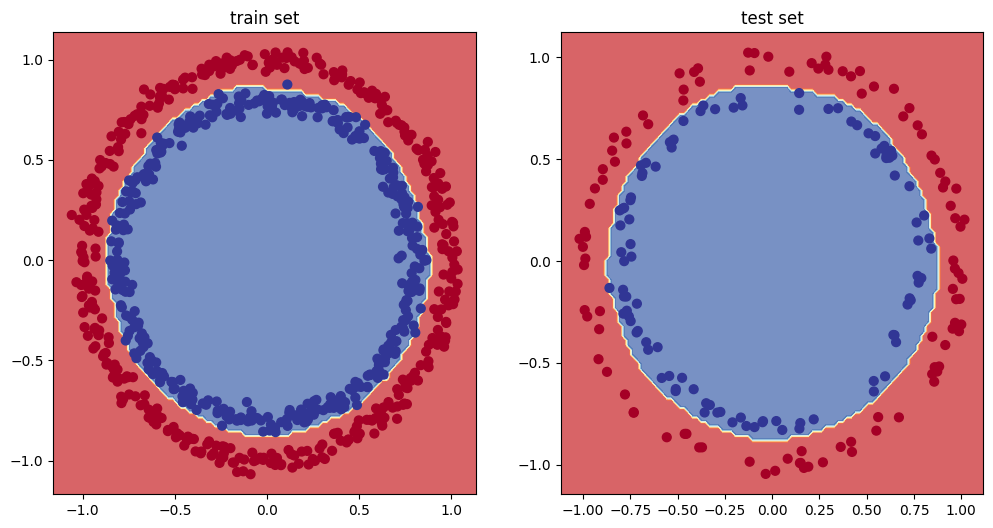

In [9]:
#plot the decision boundaries for the training and test sets:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("train set")
plot_decision_boundary(model_7,X_train,y_train)
plt.subplot(1,2,2)
plt.title("test set")
plot_decision_boundary(model_7,X_test,y_test)
plt.show()

Text(0.5, 1.0, 'Model_7 Training Curves')

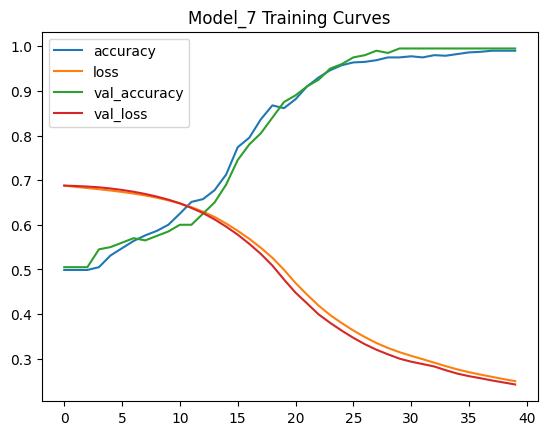

In [10]:
#plot the loss curves :
import pandas as pd
pd.DataFrame(history.history).plot()#for ever epoch there're values for loss and accuracy

plt.title("Model_7 Training Curves")

In [ ]:
#if you need to switch again to try TPE sampler:
# tpe_sampler = optuna.samplers.TPESampler(seed=42)
# study_tpe = optuna.create_study(direction='maximize', sampler=tpe_sampler)

# # Use trials from grid search to initialize the TPE study
# for trial in study_grid.trials:
#     study_tpe.add_trial(trial)

# study_tpe.optimize(objective, n_trials=10)

# # Display results
# show_all_trials(study_tpe)